## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import re
import gc
import copy

from scipy.stats import spearmanr
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm_notebook as tqdm
from transformers import RobertaTokenizer
import transformers

from radam import RAdam
from text_data import TextDataset5 as TextDataset
from roberta import CustomRoberta
from create_features import get_categorical_features
from losses_metrics import spearmanr_torch, spearmanr_np, optimize_rounding_params, get_cvs, spearmanr
from inference import infer
from common import *
from utils.helpers import init_logger, init_seed
from utils.torch import to_cpu

%matplotlib inline
pd.set_option('max_colwidth',400)

## Loading and preparing data

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)
path = 'data/'
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
test = pd.read_csv(f'{path}test.csv').fillna(' ')
train = pd.read_csv(f'{path}train.csv').fillna(' ')

In [3]:
%%time
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
seg_ids_train, ids_train = {}, {}
seg_ids_test, ids_test = {}, {}
max_seq_len = 512
for mode, df in [('train', train), ('test', test)]:
    for text, cols in [('question', ['question_title', 'question_body']), 
                       ('answer', ['question_title', 'answer'])]:
        ids, seg_ids = [], []
        for x1, x2 in tqdm(df[cols].values):
            encoded_inputs = tokenizer.encode_plus(
                x1, x2, add_special_tokens=True, max_length=max_seq_len, pad_to_max_length=True, 
                return_token_type_ids=True
            )
            ids.append(encoded_inputs['input_ids'])
            seg_ids.append(encoded_inputs['token_type_ids'])
        if mode == 'train': 
            ids_train[text] = np.array(ids)
            seg_ids_train[text] = np.array(seg_ids)
        else: 
            ids_test[text] = np.array(ids)
            seg_ids_test[text] = np.array(seg_ids)

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



CPU times: user 14.5 s, sys: 127 ms, total: 14.6 s
Wall time: 15.8 s


In [4]:
train_category, test_category, category_dict, category_dict_reverse = \
    get_categorical_features(train, test, 'category')

In [5]:
cat_features_train = train_category.reshape(-1, 1)
cat_features_test = test_category.reshape(-1, 1)
ohe = OneHotEncoder()
ohe.fit(cat_features_train)
cat_features_train = ohe.transform(cat_features_train).toarray()
cat_features_test = ohe.transform(cat_features_test).toarray()

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [6]:
for col in TARGETS:
    train[col] = train[col].rank(method="average")
train[TARGETS] = MinMaxScaler().fit_transform(train[TARGETS])
y = train[TARGETS].values.astype(np.float32)
ix = np.where(train.groupby("question_body")["host"].transform("count") == 1)[0]

In [7]:
num_workers = 10
bs = 2

## Training model

In [8]:
device = 'cuda'
pretrained_model = 'siamese_roberta_1'
head_model_name = 'siamese_roberta_1_head'
model_name = 'siamese_roberta_1_comb'
checkpoint_dir = 'checkpoints/'
early_stopping = None
n_folds = 10

In [9]:
def load_model(checkpoint_file, model):
    checkpoint = torch.load(checkpoint_file)
    model.load_state_dict(checkpoint['model_state_dict'])
    
def get_pretrained_model(fold_id):
    checkpoint_file = f'{checkpoint_dir}{pretrained_model}_fold_{fold_id+1}_best.pth'
    model = CustomRoberta(256, cat_features_train.shape[1])
    load_model(checkpoint_file, model)
    return model

def load_head(model, fold_id):
    checkpoint_file = f'{checkpoint_dir}{head_model_name}_fold_{fold_id+1}_best.pth'
    load_model(checkpoint_file, model.head)

def save_model(model):
    checkpoint_file = f'{checkpoint_dir}{model_name}_fold_{fold_id+1}_best.pth'
    torch.save({'model_state_dict': model.state_dict()}, checkpoint_file)
    
def load_saved_model(model):
    checkpoint_file = f'{checkpoint_dir}{model_name}_fold_{fold_id+1}_best.pth'
    load_model(checkpoint_file, model)

In [10]:
init_seed()
folds = GroupKFold(n_splits=n_folds).split(X=train['question_body'], groups=train['question_body'])
oofs = np.zeros((len(train), N_TARGETS))

for fold_id, (train_index, valid_index) in enumerate(folds):
    print(f'Fold {fold_id + 1} started at {time.ctime()}')
    train_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], train_index, targets=y), 
        batch_size=bs, shuffle=True, num_workers=num_workers, drop_last=False
    )
    valid_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], valid_index, targets=y), 
        batch_size=bs, shuffle=False, num_workers=num_workers, drop_last=False
    )
    
    model = get_pretrained_model(fold_id)
    load_head(model, fold_id)
    model.half()
    save_model(model)
    load_saved_model(model)
    model.float()
    
    oofs[valid_index] = infer(model, valid_loader, None, device)
    print(f'Averaged Val. score: {spearmanr_np(oofs[valid_index], y[valid_index])}')
    
    del model, train_loader, valid_loader
    gc.collect()
    
print(f'OOF score: {spearmanr_np(oofs, y)}')

Fold 1 started at Thu Jan 30 21:13:13 2020



Averaged Val. score: 0.42727623694694766
Fold 2 started at Thu Jan 30 21:13:42 2020


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)



Averaged Val. score: 0.42746514560606697
Fold 3 started at Thu Jan 30 21:14:08 2020



Averaged Val. score: 0.41163948078045565
Fold 4 started at Thu Jan 30 21:14:33 2020



Averaged Val. score: 0.39742324229031717
Fold 5 started at Thu Jan 30 21:14:59 2020



Averaged Val. score: 0.4110392803525844
Fold 6 started at Thu Jan 30 21:15:24 2020



Averaged Val. score: 0.40412393844583305
Fold 7 started at Thu Jan 30 21:15:49 2020



Averaged Val. score: 0.41927201531044417
Fold 8 started at Thu Jan 30 21:16:15 2020



Averaged Val. score: 0.4256440835192075
Fold 9 started at Thu Jan 30 21:16:41 2020



Averaged Val. score: 0.41422497989107465
Fold 10 started at Thu Jan 30 21:17:06 2020



Averaged Val. score: 0.419771975026055
OOF score: 0.41624915501915255


In [11]:
opt_ds, opt_indices = optimize_rounding_params(oofs, y)

2 4 0.48861926095192987
5 4 0.46417589097952994
9 32 0.1500413103223938
11 4 0.7521815315583723
12 4 0.5525372763492811
13 4 0.3019142897107814
14 4 0.6525019604159012
15 4 0.5902125171450449
16 16 0.7840347752112136
19 64 0.1700857058996728


In [12]:
np.array(opt_ds), np.array(opt_indices)

(array([ 4,  4, 32,  4,  4,  4,  4,  4, 16, 64]),
 array([ 2,  5,  9, 11, 12, 13, 14, 15, 16, 19]))

In [13]:
oofs_alt = oofs.copy()
train["eng"] = train["url"].apply(lambda x: x.startswith("http://english.") or x.startswith("http://ell."))
oofs_alt[np.where((~train["eng"]).values)[0], 19] = 0

In [14]:
get_cvs(oofs, y, ix)

,SpearmanR
CV,0.416249
CV unique rows,0.382360
CV ignoring hard targets,0.440614
CV unique rows ignoring hard targets,0.404309
CV w rounding,0.449898
CV unique rows w rounding,0.428115
CV ignoring hard targets w rounding,0.470601
CV unique rows ignoring hard targets w rounding,0.443194


In [15]:
get_cvs(oofs_alt, y, ix)

,SpearmanR
CV,0.420268
CV unique rows,0.386439
CV ignoring hard targets,0.440614
CV unique rows ignoring hard targets,0.404309
CV w rounding,0.450423
CV unique rows w rounding,0.428115
CV ignoring hard targets w rounding,0.470601
CV unique rows ignoring hard targets w rounding,0.443194


In [16]:
pd.DataFrame(oofs, columns=TARGETS).to_csv(f'oofs/{model_name}_oofs.csv')

In [17]:
pd.DataFrame(oofs, columns=TARGETS)

,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0.777974,0.484360,0.240398,0.681041,0.518560,0.374573,0.594761,0.438321,0.082976,0.002353,0.705912,0.027755,0.476340,0.033060,0.006758,0.201815,0.175507,0.052841,0.481828,0.000463,0.740156,0.905947,0.567747,0.963406,0.947634,0.771467,0.081616,0.049915,0.887219,0.785724
1,0.845370,0.745933,0.065866,0.493047,0.935149,0.567677,0.599782,0.775685,0.485839,0.001895,0.278523,0.077415,0.711813,0.003557,0.896352,0.035892,0.038155,0.041913,0.326998,0.003395,0.806426,0.385705,0.248967,0.643146,0.735740,0.216503,0.023291,0.018612,0.274919,0.804851
2,0.623141,0.358031,0.009601,0.681374,0.783829,0.822609,0.431702,0.272097,0.102522,0.001496,0.413032,0.108730,0.006283,0.001780,0.001226,0.185515,0.769241,0.309805,0.144095,0.000115,0.647409,0.871032,0.608521,0.925201,0.921045,0.715022,0.790183,0.298306,0.405475,0.765908
3,0.807074,0.725105,0.046032,0.846357,0.921229,0.921998,0.552402,0.605815,0.291463,0.000878,0.100738,0.859223,0.025388,0.006344,0.189556,0.100932,0.010909,0.069311,0.511250,0.003422,0.737523,0.695744,0.674560,0.747761,0.780147,0.629347,0.013693,0.062907,0.822126,0.591326
4,0.760952,0.827847,0.002844,0.669299,0.826881,0.918446,0.460661,0.343000,0.135251,0.000239,0.297391,0.428426,0.001251,0.000234,0.000522,0.001974,0.877524,0.360534,0.078821,0.000009,0.824382,0.619205,0.327729,0.728168,0.777560,0.432131,0.862532,0.208225,0.024270,0.537507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6074,0.777897,0.421507,0.165968,0.815484,0.685143,0.622973,0.566400,0.520077,0.509233,0.005347,0.546017,0.910987,0.058984,0.217807,0.025261,0.102700,0.055534,0.086268,0.526974,0.001981,0.685447,0.864647,0.655473,0.924182,0.916950,0.660363,0.128052,0.128861,0.838251,0.728975
6075,0.830059,0.391183,0.150129,0.476173,0.530770,0.386121,0.664886,0.641285,0.128623,0.010439,0.703025,0.104632,0.030758,0.011109,0.002528,0.040627,0.780514,0.419659,0.172635,0.000591,0.688221,0.862318,0.550921,0.898008,0.927709,0.657475,0.861323,0.372565,0.258826,0.854278
6076,0.615802,0.361840,0.006370,0.640198,0.731074,0.879188,0.393193,0.306873,0.193233,0.004323,0.394119,0.545434,0.003344,0.002194,0.001105,0.008865,0.817831,0.396921,0.205223,0.000196,0.528439,0.554066,0.349802,0.746895,0.743837,0.351667,0.684416,0.247324,0.457776,0.399003
6077,0.839394,0.622297,0.647123,0.567139,0.368852,0.272035,0.572984,0.751451,0.435044,0.001907,0.858615,0.811561,0.098343,0.030089,0.014534,0.014804,0.009049,0.066323,0.708007,0.000258,0.841923,0.788481,0.670714,0.871641,0.879763,0.644309,0.006526,0.056322,0.881578,0.766185


In [18]:
rs = pd.Series({col: spearmanr(oofs[:,i], y[:,i])[0] for i, col in enumerate(TARGETS)})
rs

question_asker_intent_understanding      0.383542
question_body_critical                   0.615302
question_conversational                  0.414113
question_expect_short_answer             0.308905
question_fact_seeking                    0.368708
question_has_commonly_accepted_answer    0.432340
question_interestingness_others          0.353087
question_interestingness_self            0.502939
question_multi_intent                    0.575073
question_not_really_a_question           0.085037
question_opinion_seeking                 0.486048
question_type_choice                     0.740473
question_type_compare                    0.366482
question_type_consequence                0.187835
question_type_definition                 0.364952
question_type_entity                     0.458403
question_type_instructions               0.781934
question_type_procedure                  0.378486
question_type_reason_explanation         0.674336
question_type_spelling                   0.065256


In [19]:
rs_df = pd.DataFrame(np.vstack([rs.values.flatten(), train[TARGETS].nunique()]).T, 
                     columns=['SpearmanCorr', 'NUnique'], index=rs.index)
rs_df.sort_values('SpearmanCorr', ascending=True)

,SpearmanCorr,NUnique
question_type_spelling,0.065256,3.0
question_not_really_a_question,0.085037,5.0
answer_plausible,0.164464,9.0
answer_relevance,0.181123,9.0
question_type_consequence,0.187835,5.0
answer_well_written,0.221457,9.0
answer_helpful,0.260989,9.0
question_expect_short_answer,0.308905,5.0
answer_type_procedure,0.322582,5.0
question_interestingness_others,0.353087,9.0


In [20]:
sorted_targets = rs_df.sort_values('SpearmanCorr', ascending=True).index
worst_five_targets = sorted_targets[:5]
worst_five_targets

Index(['question_type_spelling', 'question_not_really_a_question',
       'answer_plausible', 'answer_relevance', 'question_type_consequence'],
      dtype='object')

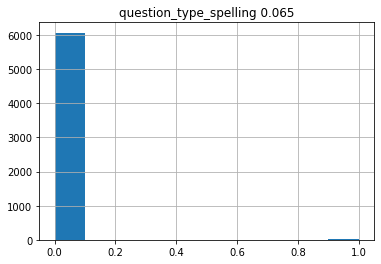

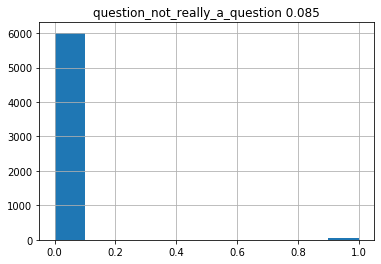

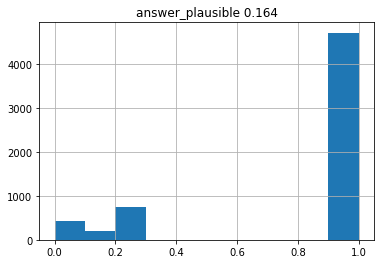

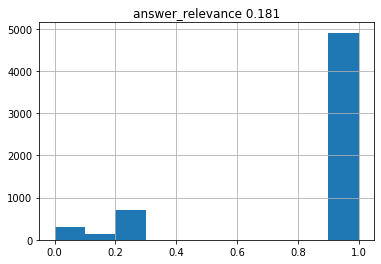

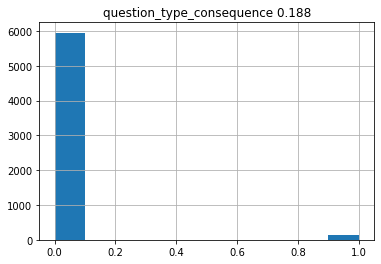

In [21]:
for col in worst_five_targets:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


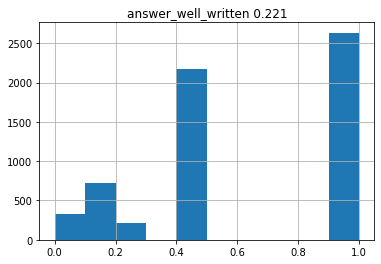

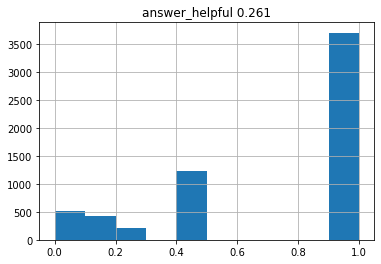

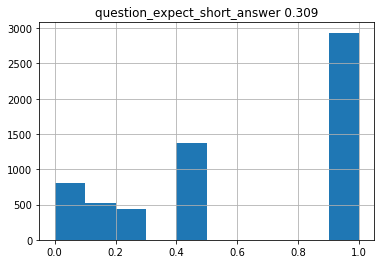

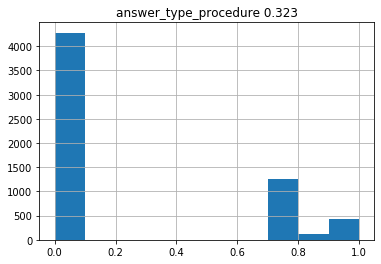

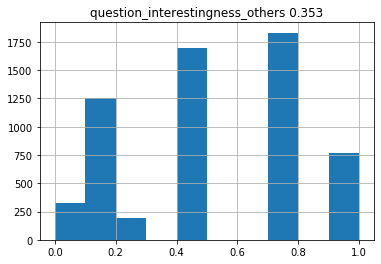

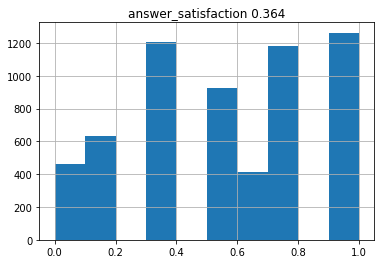

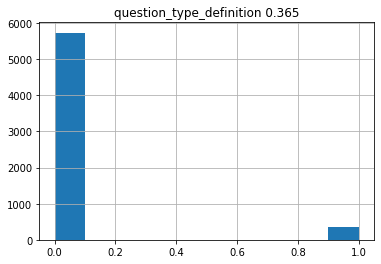

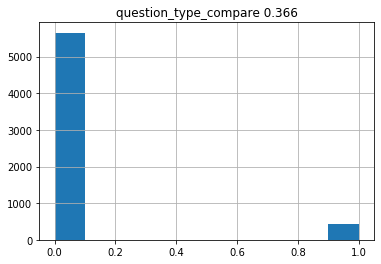

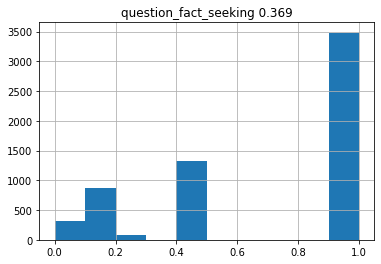

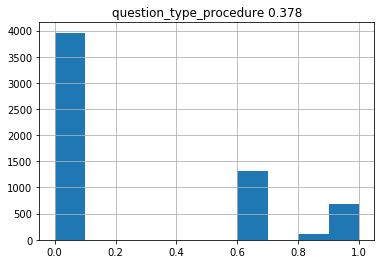

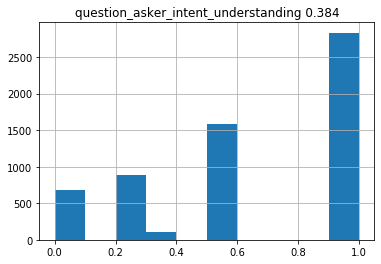

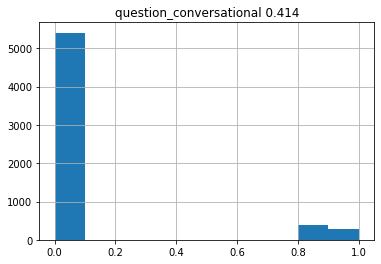

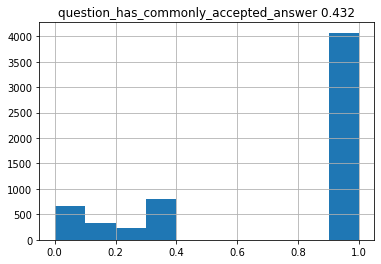

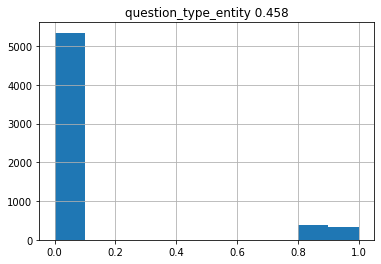

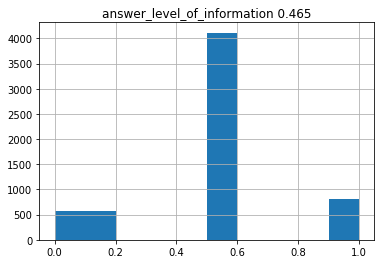

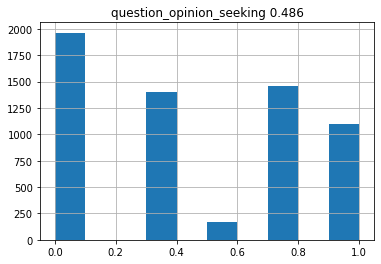

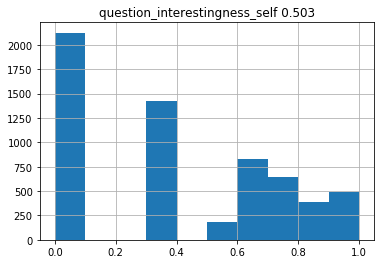

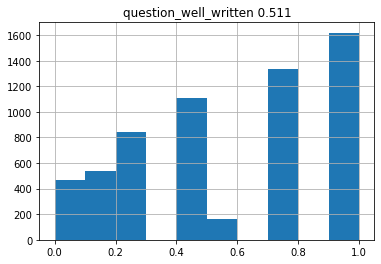

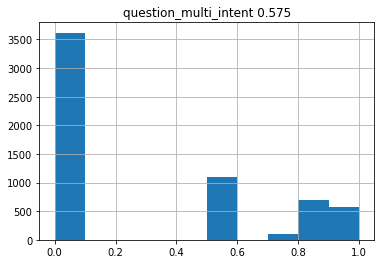

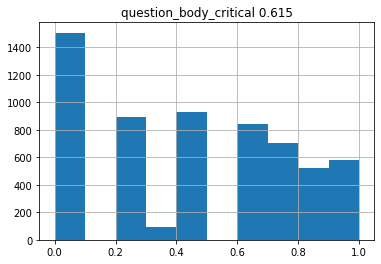

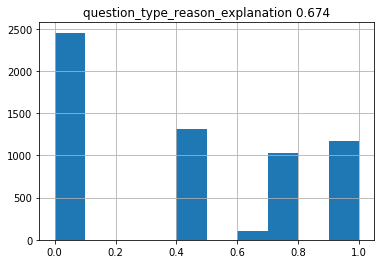

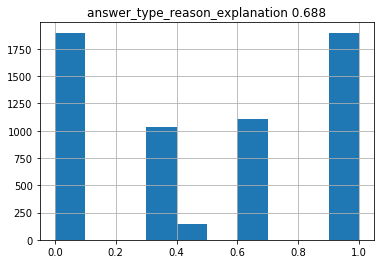

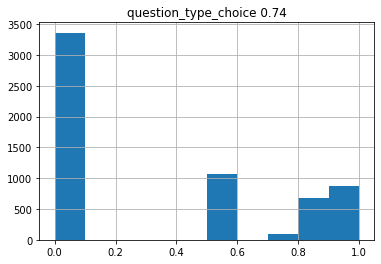

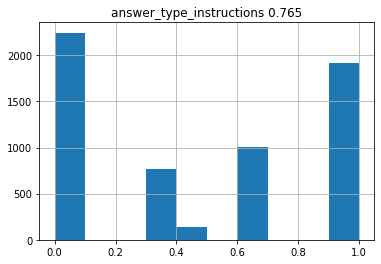

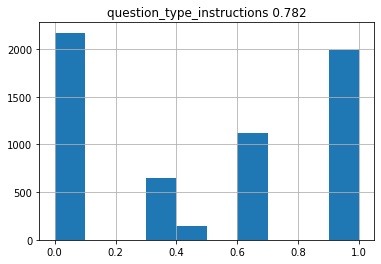

In [22]:
for col in [target for target in sorted_targets if target not in worst_five_targets]:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')